## Imports

In [184]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [185]:
df = pd.read_csv('combined_df.csv')

In [186]:
df_relevant = df[['Type', 'Genres', 'Category', 'Content Rating', 'Normal_Rating_Count', 'Normal_Rating','Normal_Reviews', 'Normal_Size', 'Normal_Installs', 'Normal_Price', 'Normal_Revenue', 'Normal_popularity']]

## Label Encoding for ordinal categorical data

In [187]:
label_encoder = LabelEncoder()
df_relevant['Content Rating'] = label_encoder.fit_transform(df_relevant['Content Rating'])
df_relevant['Genres'] = label_encoder.fit_transform(df_relevant['Genres'])
df_relevant['Category'] = label_encoder.fit_transform(df_relevant['Category'])

C:\Users\ewint\AppData\Local\Temp\ipykernel_21832\3702870009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Content Rating'] = label_encoder.fit_transform(df_relevant['Content Rating'])
C:\Users\ewint\AppData\Local\Temp\ipykernel_21832\3702870009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Genres'] = label_encoder.fit_transform(df_relevant['Genres'])
C:\Users\ewint\AppData\Local\Temp\ipykernel_21832\3702870009.py:4: SettingWithCopyWarning: 
A value is trying to be set 

## One-Hot Encoding for nominal categorical data

In [188]:
# # Example using pandas get_dummies for nominal data
# df_relevant = pd.get_dummies(df_relevant, columns=['Genres', 'Category'], drop_first=False)
# for col in df_relevant.columns:
#     if 'Genres' in col or 'Category' in col:
#         df_relevant[col] = df_relevant[col].astype(int)

## Feature selection

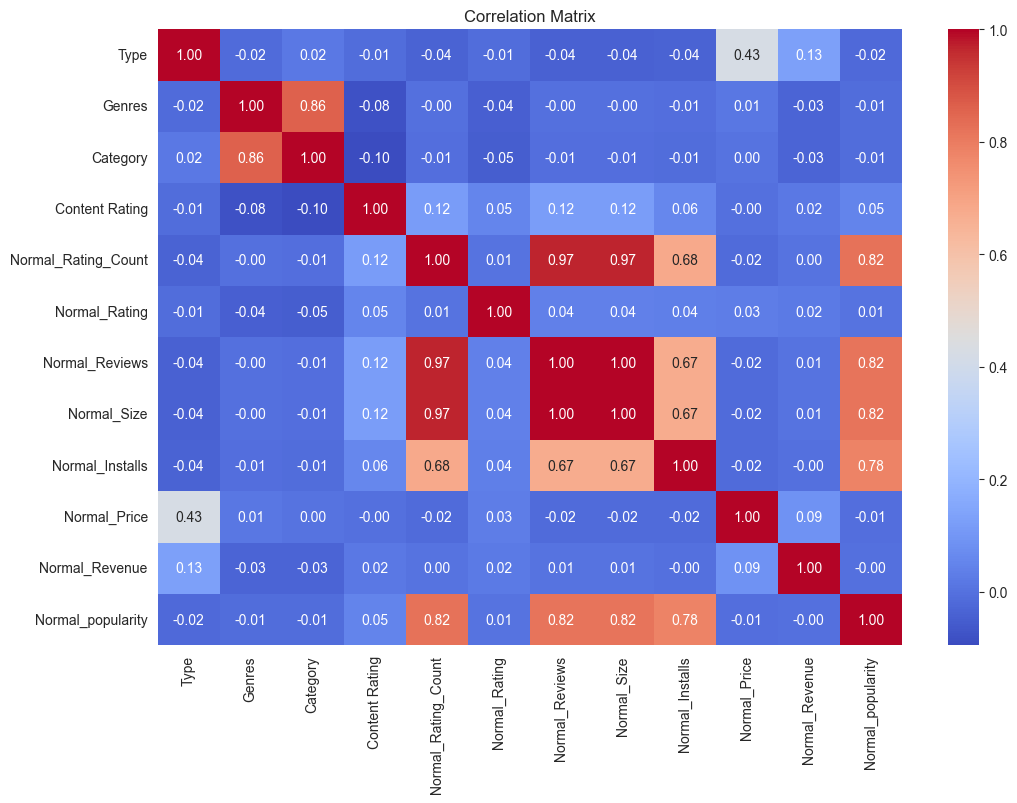

Relevant features based on correlation: ['Normal_Rating']


In [189]:
# Compute the correlation matrix
correlation_matrix = df_relevant.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Select features that have a high correlation with Normal_Rating
correlation_threshold = 0.1  # You can adjust this threshold
relevant_features = correlation_matrix.index[abs(correlation_matrix['Normal_Rating']) > correlation_threshold].tolist()

print("Relevant features based on correlation:", relevant_features)

so based on the result of the correlation, it appears that rating has low correlation with all other features, so it doesn't have strong linear relationship with others, so we should classify it using methods like decision tree or random forest (not linear regression).

## Convert normal_rating to ordinal categorical type to be able to use decision tree and random forest

In [190]:
bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = [1, 2, 3, 4, 5]

df_relevant['Rating_Category'] = pd.cut(df_relevant['Normal_Rating'], bins=bin_edges, labels=bin_labels, include_lowest=True)
print(df_relevant['Rating_Category'].value_counts())

Rating_Category
5    4480
4    1143
3     518
2      64
1      45
Name: count, dtype: int64


C:\Users\ewint\AppData\Local\Temp\ipykernel_21832\105818674.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Rating_Category'] = pd.cut(df_relevant['Normal_Rating'], bins=bin_edges, labels=bin_labels, include_lowest=True)


# Classification

## Split data

In [191]:
df_relevant = df_relevant.drop(columns=['Normal_Rating', 'Normal_popularity'])
features = df_relevant.drop(columns=['Rating_Category'])
targets = df_relevant['Rating_Category']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Standardize the features for SVM
scaler = StandardScaler()
X_train_Standard = scaler.fit_transform(X_train)
X_test_Standard = scaler.transform(X_test)

## Training the model

In [192]:
# Initialize the Classifier
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
svm_model.fit(X_train_Standard, y_train)
# Make predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test_Standard)

## Evaluate the model

In [193]:
# Evaluate the model
for y_pred, model_name in zip([y_pred_dt, y_pred_rf, y_pred_svm],['Decision Tree', 'Random Forest', 'SVM']):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print('>',model_name, 'Eval:')
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print('------------------')

> Decision Tree Eval:
Accuracy: 0.7936
Precision: 0.7898548841417838
Recall: 0.7936
F1 Score: 0.7912844289300652
------------------
> Random Forest Eval:
Accuracy: 0.8368
Precision: 0.8275073550692467
Recall: 0.8368
F1 Score: 0.8232053146761451
------------------
> SVM Eval:
Accuracy: 0.7264
Precision: 0.7173048543689321
Recall: 0.7264
F1 Score: 0.6215771916346564
------------------


C:\Users\ewint\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


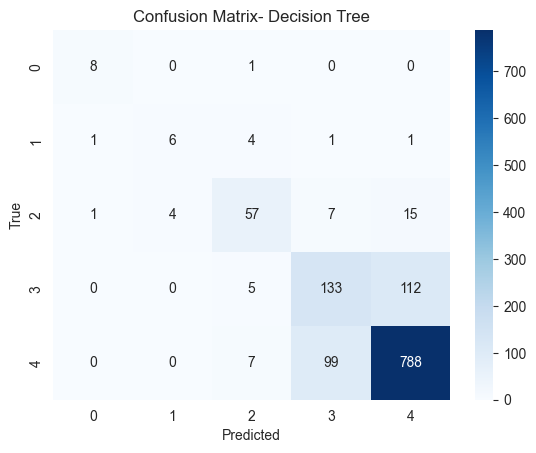

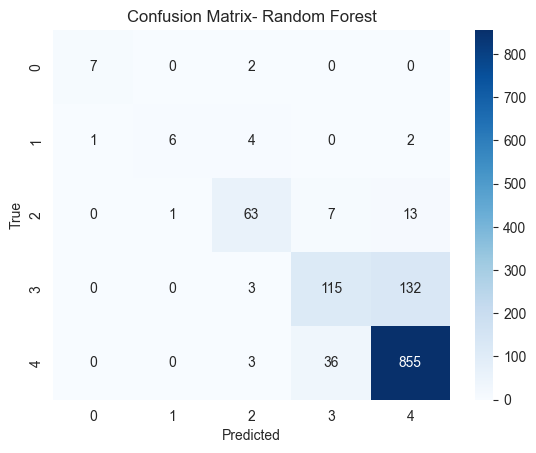

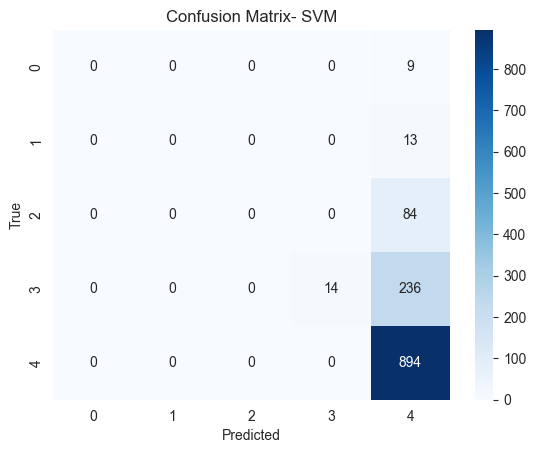

In [194]:
# Confusion Matrix
for y_pred, model_name in zip([y_pred_dt, y_pred_rf, y_pred_svm],['Decision Tree', 'Random Forest', 'SVM']):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix- {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()